In [54]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import naturalneighbor as nn
import dask
from datetime import datetime
from scipy.ndimage import convolve
dask.config.set(scheduler = "single-threaded")

In [569]:
def p_diff(a,b):
    return 100 * (np.abs(a - b)) / ((a + b) / 2)

In [772]:
# Load data sets
# --------------------------------------

ds1 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpdlprofwind4newsC1.c1.*.nc',   combine='by_coords', parallel = True)
ds2 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flxwindC1.b1.*.nc',        combine='by_coords', parallel = True)
ds3 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpinterpolatedsondeC1.c1.*.nc', combine='by_coords', parallel = True)

In [773]:
# Get reference dates from each data set
# --------------------------------------

ref_date1 = np.datetime64(datetime(pd.to_datetime(ds1.time[0].values).year, pd.to_datetime(ds1.time[0].values).month, pd.to_datetime(ds1.time[0].values).day))
ref_date2 = np.datetime64(datetime(pd.to_datetime(ds2.time[0].values).year, pd.to_datetime(ds2.time[0].values).month, pd.to_datetime(ds2.time[0].values).day))
ref_date3 = np.datetime64(datetime(pd.to_datetime(ds3.time[0].values).year, pd.to_datetime(ds3.time[0].values).month, pd.to_datetime(ds3.time[0].values).day))

In [774]:
# Ensure reference dates match
# --------------------------------------

assert(ref_date1 == ref_date2)
assert(ref_date1 == ref_date3)

In [775]:
# Compute new time axis
# --------------------------------------

interp_time1 = ((ds1.time - ref_date1) / np.timedelta64(1, 'D')).values
interp_time2 = ((ds2.time - ref_date2) / np.timedelta64(1, 'D')).values
interp_time3 = ((ds3.time - ref_date3) / np.timedelta64(1, 'D')).values

ds1['time'] = interp_time1
ds2['time'] = interp_time2
ds3['time'] = interp_time3

In [776]:
# Get interpolation values
# --------------------------------------

min_date = max([interp_time1[0], interp_time2[0]])
max_date = min([interp_time1[-1], interp_time2[-1]])

interval = min([interp_time1[1] - interp_time1[0], interp_time2[1] - interp_time2[0]])

common_time = np.arange(min_date, max_date, interval)
common_time = sorted(np.concatenate((common_time, interp_time3)))

logical_time = np.in1d(common_time, interp_time3)

In [777]:
# Rectify data sets in time
# --------------------------------------

ds1 = ds1.interp(time = common_time, kwargs={"fill_value": "extrapolate"})
ds2 = ds2.interp(time = common_time, kwargs={"fill_value": "extrapolate"})

ds4 = xr.concat([ds2, ds1], dim = 'height')

common_height = sorted(np.concatenate((ds4['height'], ds3['height'])))
logical_height = np.in1d(common_height, ds3['height'])

ds3 = ds3.interp(time = common_time, height = common_height)
ds4 = ds4.interp(time = common_time, height = common_height)

In [778]:
# Combine data sets and free memory
# --------------------------------------

u_data = ds4['u'].values
v_data = ds4['v'].values

u_back_data = ds3['u'].values
v_back_data = ds3['v'].values

# kernel = np.array([
#     [1, 1, 1],
#     [1, 1, 1],
#     [1, 1, 1],
# ])

# neighbor_count = convolve(u_data, kernel, mode = 'constant', cval = 0)

# threshold = 4
# mask = (neighbor_count <= threshold).astype(float)

# mask[mask == 0] = np.nan

# u_data = u_data * mask
# v_data = v_data * mask

# for t in range(len(ds4['time'])):
#     for h in range(len(ds4['height'])):
#         if ((np.isnan(u_data[t, h])) & ((~logical_time[t]) | (logical_height[h]))):
#             u_data[t, h] = u_back_data[t, h]
#             v_data[t, h] = v_back_data[t, h]

# diff_mat_u = u_data - u_back_data
# diff_mat_v = v_data - v_back_data

# u_bias = np.nanmedian(diff_mat_u, axis = 0)
# v_bias = np.nanmedian(diff_mat_v, axis = 0)

# u_back_data = u_back_data + u_bias
# v_back_data = v_back_data + v_bias

# diff_mat_u = u_back_data / u_data
# diff_mat_v = v_back_data / v_data

diff_mat_u = u_data / u_back_data
diff_mat_v = v_data / v_back_data

u_bias = np.nanmedian(diff_mat_u, axis = 0)
v_bias = np.nanmedian(diff_mat_v, axis = 0)

u_back_data = u_back_data * u_bias
v_back_data = v_back_data * v_bias

# for t in range(len(ds4['time'])):
#     for h in range(len(common_height)):
#         if ((np.isnan(u_data[t, h])) & ((~logical_time[t]) & (logical_height[h]))):
#             # if p_diff(u_data[t, h], u_back_data[t, h]) > 10
#             u_data[t, h] = u_back_data[t, h]
#             v_data[t, h] = v_back_data[t, h]

for t in range(len(ds4['time'])):
    for h in range(len(common_height)):
        if ((np.isnan(u_data[t, h]))):
            # if p_diff(u_data[t, h], u_back_data[t, h]) > 10
            u_data[t, h] = u_back_data[t, h]
            v_data[t, h] = v_back_data[t, h]

ds4['u'] = (('time', 'height'), u_data)
ds4['v'] = (('time', 'height'), v_data)

del ds1
del ds2
# del ds3
# del u_back_data
del v_back_data

/var/folders/2l/_j37v83j2kj5nqw668xp9snc_d_4cz/T/ipykernel_68570/4078481823.py:44: RuntimeWarning: divide by zero encountered in divide
  diff_mat_u = u_data / u_back_data
/Users/smata/miniconda3/envs/vscode_env/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


(0.0, 2000.0)

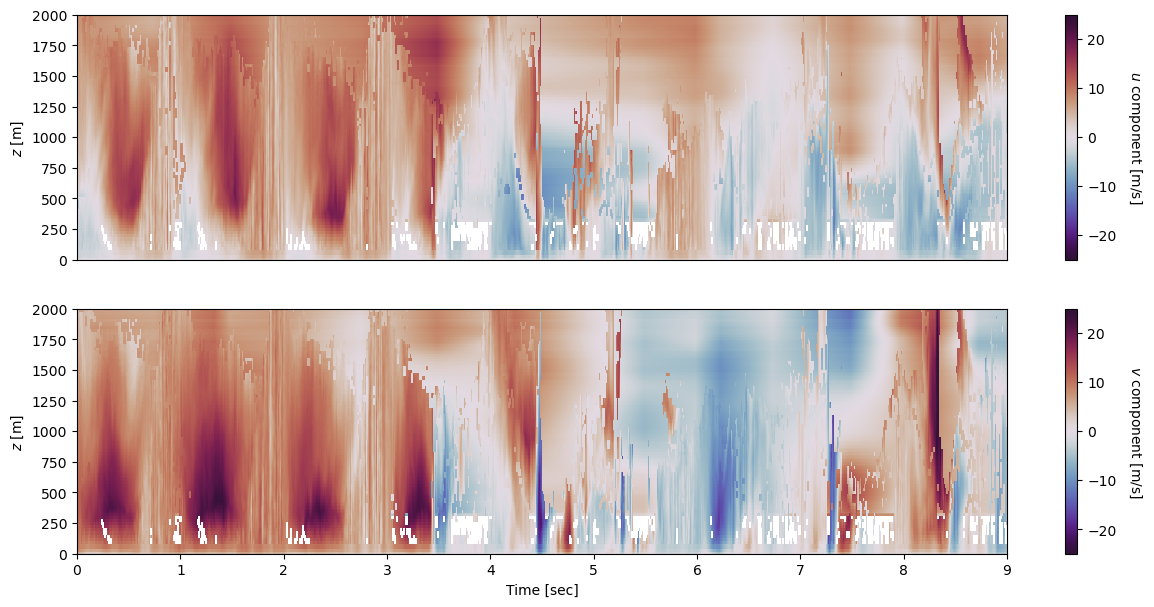

In [779]:
# Plot rectified data
# --------------------------------------

fig,ax = plt.subplots(2, 1, figsize = (15, 7))

cntf = ax[0].pcolormesh(ds4.time, ds4.height,(u_data).T, vmin = -25, vmax = 25, cmap = 'twilight_shifted')

# cntf = ax[0].pcolormesh(ds4.time, ds4.height,(ds4['u']).T, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
ax[0].set_ylabel("$z$ [m]")
ax[0].set_ylim([0, 2000])
ax[0].get_xaxis().set_ticks([])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

cntf = ax[1].pcolormesh(ds4.time, ds4.height,(v_data).T, vmin = -25, vmax = 25, cmap = 'twilight_shifted')

# cntf = ax[1].pcolormesh(ds4.time, ds4.height,(ds4['v']).T, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
ax[1].set_xlabel("Time [sec]")
ax[1].set_ylabel("$z$ [m]")
ax[1].set_ylim([0, 2000])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

In [739]:
# Pre-process for NN interpolation
# --------------------------------------

x, y = np.meshgrid(common_time, common_height, indexing = 'ij')

xi = np.ravel(x, order = 'C')
yi = np.ravel(y, order = 'C')
zi = np.zeros(len(xi))

# u = (ds4['u'].copy(deep = True)).values
u_flat = np.ravel(u_data, order = 'C')

# v = (ds4['v'].copy(deep = True)).values
v_flat = np.ravel(v_data, order = 'C')

nan_ind = np.argwhere(~np.isnan(u_flat))

u_flat = u_flat[nan_ind].squeeze()
v_flat = v_flat[nan_ind].squeeze()
xi = xi[nan_ind].squeeze()
yi = yi[nan_ind].squeeze()
zi = zi[nan_ind].squeeze()

In [740]:
# Interpolate
# --------------------------------------

tdef    = [min_date, max_date, (1/4)/24]
zdef    = [0, 2000, 20] # [m]
griddef = [tdef, zdef, [-0.5, 0.5, 1]]

points = np.stack((xi, yi, zi), axis = -1)

u_nn_interp = nn.griddata(points, u_flat, griddef).squeeze() # squeeze out "z" dimension
v_nn_interp = nn.griddata(points, v_flat, griddef).squeeze() # squeeze out "z" dimension

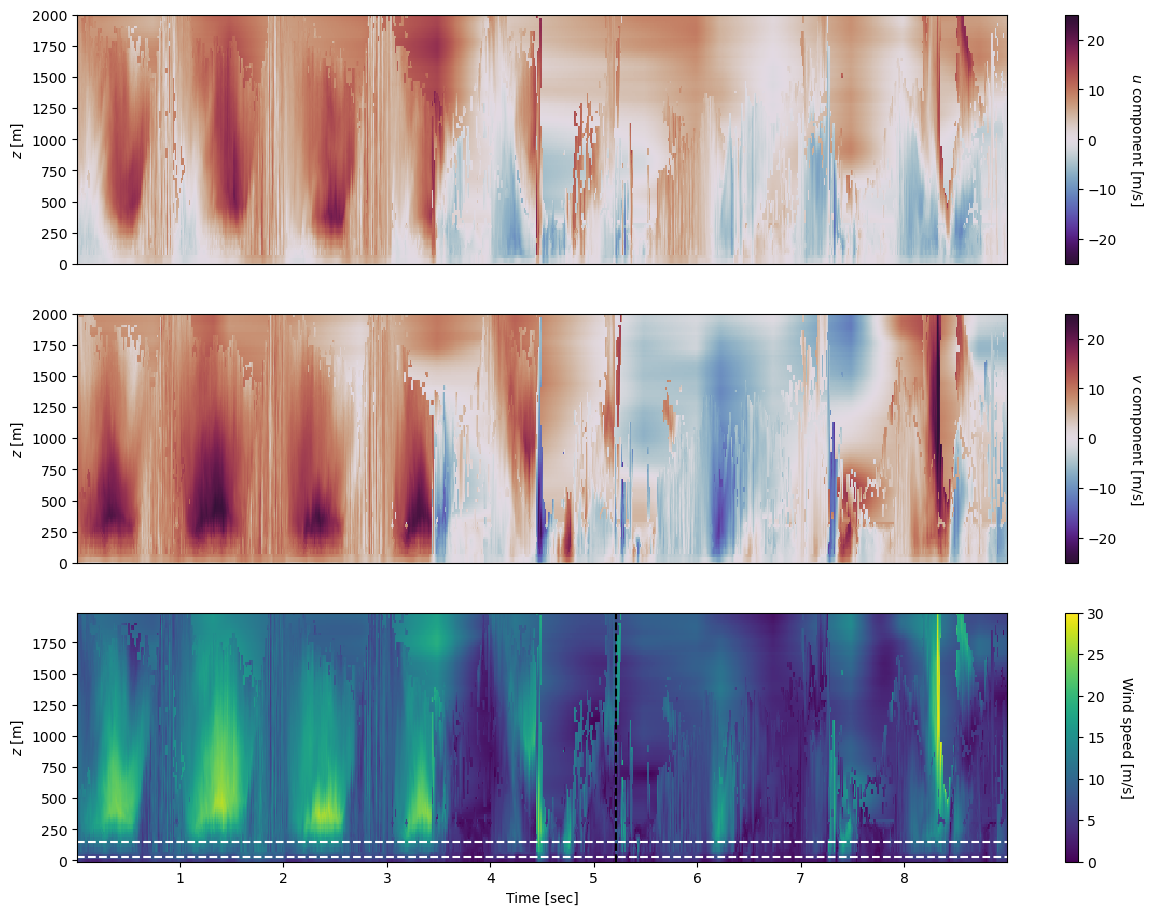

In [741]:
# Plot interpolated data [contour]
# --------------------------------------

times   = np.arange(tdef[0], tdef[1], tdef[2])
heights = np.arange(zdef[0], zdef[1], zdef[2])

hub_height = 88.5
diameter   = 127

fig,ax = plt.subplots(3, 1, figsize = (15, 11))

cntf = ax[0].pcolormesh(times, heights, u_nn_interp.T, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
ax[0].set_ylabel("$z$ [m]")
ax[0].set_ylim([0, 2000])
ax[0].get_xaxis().set_ticks([])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

cntf = ax[1].pcolormesh(times, heights, v_nn_interp.T, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
ax[1].set_ylabel("$z$ [m]")
ax[1].set_ylim([0, 2000])
ax[1].get_xaxis().set_ticks([])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

cntf = ax[2].pcolormesh(times, heights, (v_nn_interp.T**2 + u_nn_interp.T**2)**(1/2), vmin = 0, vmax = 30, cmap = 'viridis')
cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[2].set_ylabel("$z$ [m]")
ax[2].set_xlabel("Time [sec]")
# ax[2].set_ylim([0, 500])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

ax[2].axhline(y = hub_height - diameter/2, color = 'w', linestyle = '--')
ax[2].axhline(y = hub_height + diameter/2, color = 'w', linestyle = '--')

ax[2].axvline(times[500], color = 'k', linestyle = '--')


In [742]:
# Smooth data
# --------------------------------------

u_smooth = np.zeros(u_nn_interp.T.shape)
v_smooth = np.zeros(u_nn_interp.T.shape)

for i in range(u_nn_interp.shape[0]):
    coeff = np.polyfit(heights, u_nn_interp.T[:,i],6)
    xn = heights
    yn = np.poly1d(coeff)
    u_smooth[:,i] = yn(xn)

    coeff = np.polyfit(heights, v_nn_interp.T[:,i],6)
    xn = heights
    yn = np.poly1d(coeff)
    v_smooth[:,i] = yn(xn)

wspd_smooth = (v_smooth**2 + u_smooth**2)**(1/2)


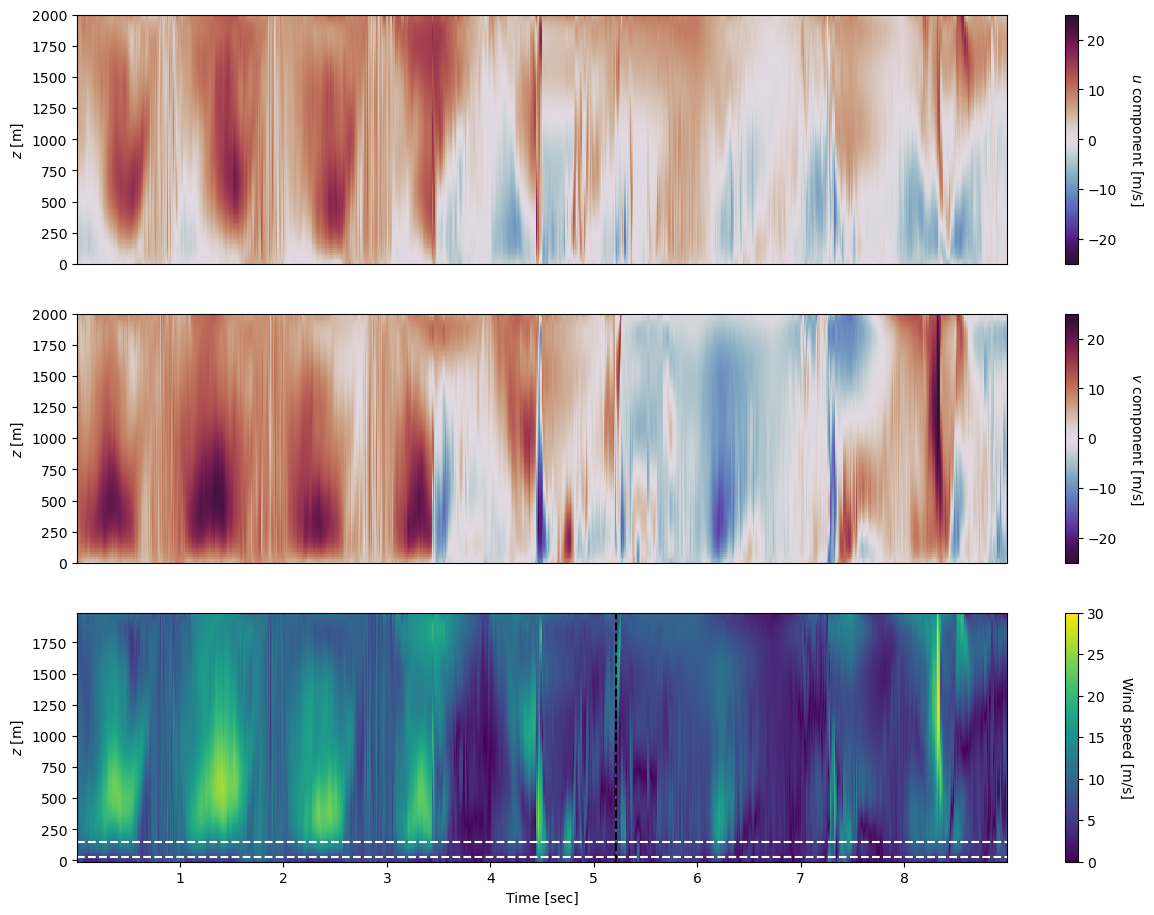

In [743]:
# Plot smoothed
# --------------------------------------

fig,ax = plt.subplots(3, 1, figsize = (15, 11))

cntf = ax[0].pcolormesh(times, heights, u_smooth, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
ax[0].set_ylabel("$z$ [m]")
ax[0].set_ylim([0, 2000])
ax[0].get_xaxis().set_ticks([])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

cntf = ax[1].pcolormesh(times, heights, v_smooth, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
ax[1].set_ylabel("$z$ [m]")
ax[1].set_ylim([0, 2000])
ax[1].get_xaxis().set_ticks([])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

cntf = ax[2].pcolormesh(times, heights, wspd_smooth, vmin = 0, vmax = 30, cmap = 'viridis')
cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[2].set_ylabel("$z$ [m]")
ax[2].set_xlabel("Time [sec]")
# ax[2].set_ylim([0, 500])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

ax[2].axhline(y = hub_height - diameter/2, color = 'w', linestyle = '--')
ax[2].axhline(y = hub_height + diameter/2, color = 'w', linestyle = '--')

ax[2].axvline(times[500], color = 'k', linestyle = '--')

Text(0, 0.5, '$z$ [m]')

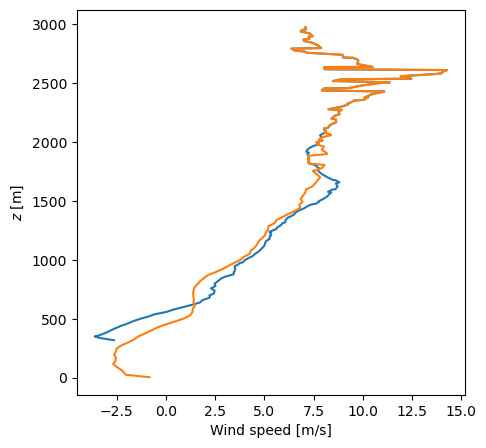

In [780]:
fig,ax = plt.subplots(figsize = (5, 5))

# i = 315
i = 245

profiles = (v_nn_interp.T**2 + u_nn_interp.T**2)**(1/2)

# ax.plot(profiles[:,i], heights)
# ax.plot(wspd_smooth[:,i], heights)
ax.plot(u_back_data[i,:], ds3['u'].height)
ax.plot(u_data[i,:], ds3['u'].height)
ax.set_xlabel('Wind speed [m/s]')
ax.set_ylabel('$z$ [m]')

In [748]:
wspd_smooth.shape

(100, 863)

In [80]:
# Compute common time axis and cyclical time variables
# --------------------------------------

new_ref_times = np.empty(u_nn_interp.shape[0], dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)

for i in range(u_nn_interp.shape[0]):
    new_ref_times[i] = np.datetime64(pd.Timestamp(ref_date1) + pd.Timedelta(times[i], 'D'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

Text(0, 0.5, 'Day of year')

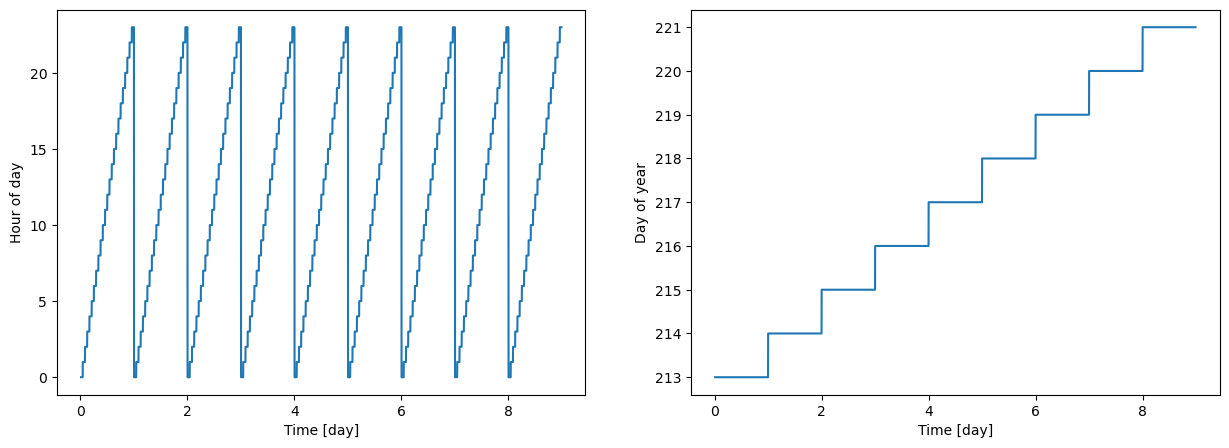

In [81]:
fig,ax = plt.subplots(1,2,figsize = (15, 5))

ax[0].plot(times, hr_per_day)
ax[0].set_xlabel('Time [day]')
ax[0].set_ylabel('Hour of day')

ax[1].plot(times, day_per_yr)
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel('Day of year')

In [82]:
# Save data
# --------------------------------------

full_xr = xr.Dataset({
    'u': xr.DataArray(
                data   = u_nn_interp.T,   # enter data here
                dims   = ['height', 'time'],
                coords = {'height': heights, 'time': new_ref_times},
    ),
    'v': xr.DataArray(
                data   = v_nn_interp.T,   # enter data here
                dims   = ['height', 'time'],
                coords = {'height': heights, 'time': new_ref_times},
    ),
    'hr_day': xr.DataArray(
                data   = hr_per_day,   # enter data here
                dims   = ['time'],
                coords = {'time': new_ref_times},
    ),
    'day_yr': xr.DataArray(
                data   = day_per_yr,   # enter data here
                dims   = ['time'],
                coords = {'time': new_ref_times},
    ),
        })
full_xr.to_netcdf('/Users/smata/Downloads/processedData/ML_data.nc')

full_xr

<xarray.Dataset>
Dimensions:  (height: 100, time: 12931)
Coordinates:
  * height   (height) int64 0 20 40 60 80 100 ... 1880 1900 1920 1940 1960 1980
  * time     (time) datetime64[ns] 2023-08-01T00:15:00 ... 2023-08-09T23:44:5...
Data variables:
    u        (height, time) float64 -5.906 -7.798 -8.196 ... -0.3226 -0.277
    v        (height, time) float64 1.223 2.031 2.14 ... -0.1763 -0.1883 -0.2043
    hr_day   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 23.0 23.0 23.0 23.0 23.0
    day_yr   (time) float64 213.0 213.0 213.0 213.0 ... 221.0 221.0 221.0 221.0